In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import pandas as pd
import numpy as np
from tqdm import tqdm
from ste import STE

# Time-series dataset

In [2]:
# Define the country name.
COUNTRY = "Yemen"

In [3]:
PATH_TO_DATA_FOLDER = "../Dataset time-series/output_data/" + COUNTRY + "/"

In [4]:
# Load the time-series dataset.
df = pd.read_csv(PATH_TO_DATA_FOLDER + "%s-day.csv" % COUNTRY, header = [0, 1], index_col = 0)
df.index.name = "Datetime"
df.index = pd.to_datetime(df.index)
freq = "D"
df.index.freq = freq

In [5]:
df.columns.get_level_values(1).unique()

Index(['1 Month Anomaly Rainfalls (%)', '3 Months Anomaly Rainfalls (%)',
       'Code', 'Exchange rate', 'FCG <= 2', 'Fatalities', 'Lat', 'Lon', 'NDVI',
       'NDVI Anomaly', 'Population', 'Price cereals and tubers',
       'Rainfalls (mm)', 'Ramadan', 'rCSI >= 19'],
      dtype='object', name='Indicator')

In [6]:
# Consider only some indicators for the analysis with symbolic transfer entropy.
INDICATORS_TO_CONSIDER = ["FCG <= 2", "1 Month Anomaly Rainfalls (%)", "3 Months Anomaly Rainfalls (%)", "NDVI", "Price cereals and tubers", "Exchange rate", "Fatalities", "NDVI Anomaly", "rCSI >= 19", "Rainfalls (mm)"]
df = pd.concat([df.loc[:, (slice(None), feature)] for feature in INDICATORS_TO_CONSIDER], axis = 1).sort_index(axis = 1)
df

AdminStrata                         Abyan                                 \
Indicator   1 Month Anomaly Rainfalls (%) 3 Months Anomaly Rainfalls (%)   
Datetime                                                                   
2018-08-22                      90.454758                     111.487446   
2018-08-23                      89.927580                     110.382403   
2018-08-24                      89.436780                     109.316308   
2018-08-25                      88.982357                     108.289161   
2018-08-26                      88.564312                     107.300961   
...                                   ...                            ...   
2020-08-31                     162.025191                     200.286329   
2020-09-01                     159.268848                     198.375167   
2020-09-02                     156.609087                     196.526964   
2020-09-03                     154.045906                     194.741718   
2020-09-04                     151.579307                     193.019431   

AdminStrata                                                             \
Indicator   Exchange rate   FCG <= 2 Fatalities      NDVI NDVI Anomaly   
Datetime                                                                 
2018-08-22       0.133546  31.809805       10.0  0.098889    98.450151   
2018-08-23       0.136952  32.374660       10.0  0.098958    98.353086   
2018-08-24       0.140358  33.772110       10.0  0.099033    98.254291   
2018-08-25       0.143765  34.533738       10.0  0.099113    98.153766   
2018-08-26       0.147171  32.327892       10.0  0.099197    98.051510   
...                   ...        ...        ...       ...          ...   
2020-08-31       0.619324  42.763420       48.0  0.172453   144.744706   
2020-09-01       0.622186  43.810070       38.0  0.172852   144.749188   
2020-09-02       0.625047  43.068170       38.0  0.173202   144.721651   
2020-09-03       0.627908  44.793680       38.0  0.173502   144.662094   
2020-09-04       0.630769  44.438290       39.0  0.173754   144.570519   

AdminStrata                                                     ...  \
Indicator   Price cereals and tubers Rainfalls (mm) rCSI >= 19  ...   
Datetime                                                        ...   
2018-08-22                  0.164757        12.9544  37.421880  ...   
2018-08-23                  0.166101        13.0949  37.346207  ...   
2018-08-24                  0.167444        13.2354  37.999408  ...   
2018-08-25                  0.168787        13.3759  36.068234  ...   
2018-08-26                  0.170131        13.5164  38.218464  ...   
...                              ...            ...        ...  ...   
2020-08-31                  0.502412        20.4773  38.396000  ...   
2020-09-01                  0.505260        20.2776  38.852410  ...   
2020-09-02                  0.508108        20.0779  39.113680  ...   
2020-09-03                  0.510956        19.8782  39.012960  ...   
2020-09-04                  0.513804        19.6785  39.850460  ...   

AdminStrata                         Taizz                                 \
Indicator   1 Month Anomaly Rainfalls (%) 3 Months Anomaly Rainfalls (%)   
Datetime                                                                   
2018-08-22                      93.865658                     147.652361   
2018-08-23                      94.296436                     145.973629   
2018-08-24                      94.778817                     144.313356   
2018-08-25                      95.312802                     142.671542   
2018-08-26                      95.898390                     141.048187   
...                                   ...                            ...   
2020-08-31                     155.333204                     162.636261   
2020-09-01                     152.262088                     162.045383   
2020-09-02                     149.358157                     161.4

In [7]:
PROVINCES = df.columns.get_level_values(0).unique()
PROVINCES

Index(['Abyan', 'Aden', 'Al Bayda', 'Al Dhale'e', 'Al Hudaydah', 'Al Jawf',
       'Al Maharah', 'Al Mahwit', 'Amanat Al Asimah', 'Amran', 'Dhamar',
       'Hajjah', 'Ibb', 'Lahj', 'Marib', 'Raymah', 'Sa'ada', 'Sana'a',
       'Shabwah', 'Taizz'],
      dtype='object', name='AdminStrata')

In [8]:
PREDICTORS = df.columns.get_level_values(1).unique()
PREDICTORS

Index(['1 Month Anomaly Rainfalls (%)', '3 Months Anomaly Rainfalls (%)',
       'Exchange rate', 'FCG <= 2', 'Fatalities', 'NDVI', 'NDVI Anomaly',
       'Price cereals and tubers', 'Rainfalls (mm)', 'rCSI >= 19'],
      dtype='object', name='Indicator')

In [9]:
# Assign a color to each indicator.
#cols = plt.get_cmap("tab10")
cols = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
        (1.0, 0.4980392156862745, 0.054901960784313725),
        (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
        (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
        (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
        (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
        (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
        (0.09019607843137255, 0.7450980392156863, 0.8117647058823529), 
        (1.0, 1.0, 0.2), 
        (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

colors = dict()
for i,indicator in enumerate(reversed(PREDICTORS)):
    #colors[indicator] = cols(i)
    colors[indicator] = cols[i]

# Importance of the indicators

In [10]:
df_feature_importance = df.drop("FCG <= 2", axis = 1, level = 1)

In [11]:
rows_ste = list()
rows_ste_rank = list()

def feature_importance(group):
    adminstrata = group.name
    rows = dict()
    for indicator in df_feature_importance.columns.get_level_values(1).unique():
        result = STE.calc_ste(group[adminstrata][indicator], df[adminstrata]["FCG <= 2"], m = 3, kx = 1, ky = 1, h = 1)
        rows[indicator] = result
    row = pd.Series(rows)
    row.name = adminstrata + " - FCG $\leq$ 2"
    rows_ste.append(row)
    rows_ste_rank.append(row.rank(method = "max", ascending = False))

tqdm.pandas()
df_feature_importance.groupby(level = 0, axis = 1).progress_apply(feature_importance);
T_fcs = pd.concat(rows_ste, axis = 1).transpose()
T_fcs_rank = pd.concat(rows_ste_rank, axis = 1).transpose()

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.59it/s]


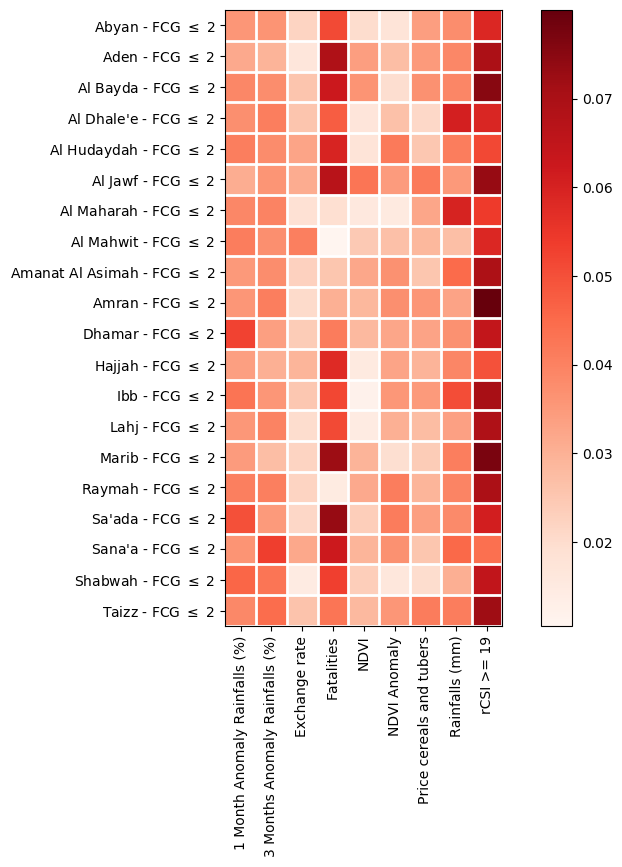

In [12]:
with plt.style.context("default"):
    fig, ax = plt.subplots(figsize = (10, 8))
    im = ax.imshow(T_fcs.astype(float), cmap = "Reds")
    cbar = fig.colorbar(im, ax = ax)
    #clb = plt.colorbar()
    #cbar.set_label("STE", rotation = 270)

    ax.set_xticks(range(len(T_fcs.columns)))
    ax.set_yticks(range(len(T_fcs.index)))
    ax.set_xticklabels(T_fcs.columns, rotation = 90)
    ax.set_yticklabels(T_fcs.index)
    #ax.set_xlabel("Indicator")
    #ax.set_ylabel("AdminStrata")
    #ax.set_title("T - Influence different indicators for FCS")
    for i in range(T_fcs.shape[0]):
        ax.axhline(i + 0.5, color = "white", lw = 2)
    for i in range(T_fcs.shape[1]):
        ax.axvline(i + 0.5, color = "white", lw = 2)
        
    # Save the figure.
    fig.savefig("./output_images/Importance_%s.png" % COUNTRY, bbox_inches = "tight", dpi = 300)

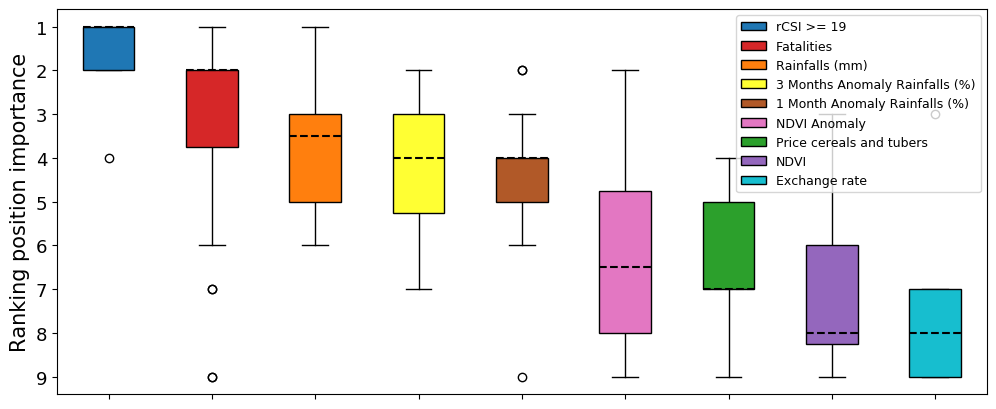

In [13]:
with plt.style.context("default"):
    fig, ax = plt.subplots(figsize = (12, 5))
    T_fcs_rank = T_fcs_rank.astype(int)
    meds = T_fcs_rank.mean()
    meds.sort_values(ascending = True, inplace = True)
    T_fcs_rank_sort = T_fcs_rank[meds.index]
    #T_fcs_rank_sort = T_fcs_rank_sort[['rCSI', 'Fatalities', 'Rainfall (mm)', 'Rainfall Anomaly', 'NDVI Anomaly', 'Price cereals and tubers', 'Exchange rate']]
    #cm = plt.cm.get_cmap("tab20")
    #colors = [cm(val/len(T_fcs_rank_sort.columns)) for val in range(len(T_fcs_rank_sort.columns))]
    bplot = ax.boxplot(T_fcs_rank_sort.T, patch_artist = True, medianprops = {"linestyle": "--", "linewidth": 1.5, "color": "black"}) 
    # Fill with colors.
    legends = list()
    for patch, indicator in zip(bplot["boxes"], T_fcs_rank_sort.columns):
        patch.set_facecolor(colors[indicator])
        patch.set_label(indicator)
        legends.append(patch)
    
    ax.invert_yaxis()
    #ax.set_xlabel("Indicator")
    ax.set_ylabel("Ranking position importance", fontsize = 15)
    ax.tick_params(labelsize = 13)
    ax.set_xticklabels([""]*len(T_fcs_rank_sort.columns), rotation = 0, fontsize = 15)  

    ax.legend(legends, T_fcs_rank_sort.columns, loc = "upper right", prop = {"size": 9})
    
    # Save the figure.
    fig.savefig("./output_images/Ranking_%s.png" % COUNTRY, bbox_inches = "tight", dpi = 300)

# Lag importance

In [14]:
# Compute the entropy rate of the endogenous indicators (FCS indicator)..
lags = 15
def history_length_Y(serie):
    adminstrata = serie.name[0]
    y = list()
    for k in range(lags):
        result = STE.entropy_rate(serie, m = 3, k = k+1, h = 1)
        y.append(result)  
    return y  

tqdm.pandas()
df_results_Y = df.xs("FCG <= 2", axis = 1, level = 1, drop_level = False).progress_apply(history_length_Y)
df_results_Y.index = df_results_Y.index  + 1
df_results_Y.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:34<00:00,  1.74s/it]


AdminStrata,Abyan,Aden,Al Bayda,Al Dhale'e,Al Hudaydah,Al Jawf,Al Maharah,Al Mahwit,Amanat Al Asimah,Amran,Dhamar,Hajjah,Ibb,Lahj,Marib,Raymah,Sa'ada,Sana'a,Shabwah,Taizz
Indicator,FCG <= 2,FCG <= 2,FCG <= 2,FCG <= 2,FCG <= 2,FCG <= 2,FCG <= 2,FCG <= 2,FCG <= 2,FCG <= 2,FCG <= 2,FCG <= 2,FCG <= 2,FCG <= 2,FCG <= 2,FCG <= 2,FCG <= 2,FCG <= 2,FCG <= 2,FCG <= 2
1,1.442448,1.473247,1.484511,1.440820,1.419284,1.475093,1.473790,1.471507,1.439597,1.455126,1.487290,1.444372,1.446578,1.454508,1.476334,1.451367,1.453495,1.473099,1.473660,1.477399
2,1.419101,1.435700,1.464694,1.431511,1.387863,1.444406,1.448467,1.452049,1.420063,1.415397,1.470606,1.426824,1.431674,1.433945,1.443542,1.426431,1.431357,1.445957,1.444692,1.440704
3,1.325420,1.359317,1.374823,1.366188,1.313017,1.360477,1.375457,1.384598,1.334194,1.335443,1.406611,1.326680,1.332355,1.366686,1.362043,1.319163,1.355414,1.356577,1.381910,1.347792
4,1.136406,1.168373,1.185007,1.138347,1.145149,1.142357,1.126341,1.167618,1.126774,1.119476,1.178142,1.109592,1.151691,1.158021,1.169524,1.100398,1.147812,1.161591,1.179619,1.128561
5,0.826013,0.792299,0.778283,0.812539,0.889550,0.767591,0.803492,0.811635,0.773357,0.792648,0.769266,0.815355,0.828122,0.822210,0.780099,0.792459,0.810021,0.801570,0.788377,0.786066


In [15]:
#df_results_Y = df_results_Y.diff().dropna()

In [16]:
def plot_quantiles(df, title = None, xaxis = None, yaxis = None, label = None):
    with plt.style.context("default"):
        # Define the subplot figure.
        fig, axs = plt.subplots(figsize = (15, 7))
        value_statistic = df.agg([lambda x: x.quantile(0.25), np.mean, lambda x: x.quantile(0.75)], axis = 1)
        value_statistic.columns = ["lower_quantile", "mean", "upper_quantile"]
        # Plot.
        value_statistic["mean"].plot(style = ".-", label = label, ax = axs, ms = 12, c = colors["FCG <= 2"])
        axs.fill_between(x = value_statistic["mean"].index, y1 = value_statistic["lower_quantile"], 
                         y2 = value_statistic["upper_quantile"], color = colors["FCG <= 2"], alpha = 0.3)
        # Set attributes of the plot.
        axs.set_title(title)
        axs.legend(loc = "best", prop = {"size": 15})
        axs.set_xlabel(xaxis, fontsize = 18)
        axs.set_ylabel(yaxis, fontsize = 18)
        axs.tick_params(labelsize = 15)
        axs.set_xticks(np.arange(1, 16))
    return fig, axs

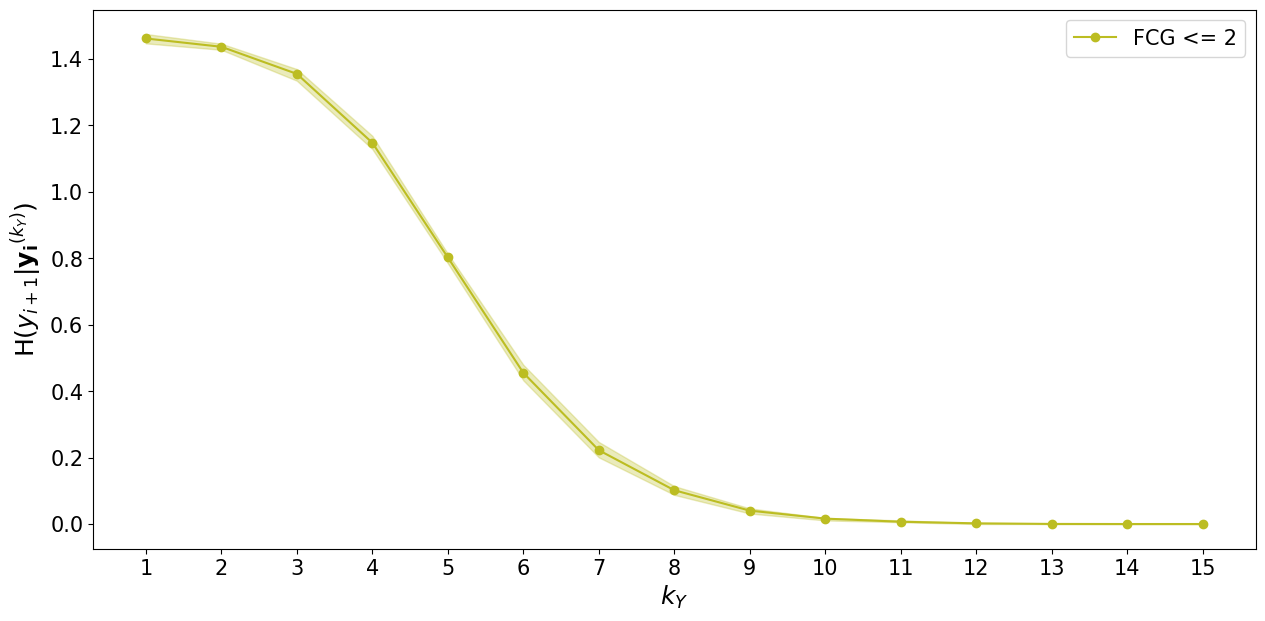

In [17]:
fig, axs = plot_quantiles(df_results_Y, xaxis = "$k_{Y}$", yaxis = "H($y_{i+1}|\mathbf{y_{i}}^{(k_Y)}$)", label = "FCG <= 2")

In [18]:
fig.savefig("./output_images/entropy_rate_%s.png" % COUNTRY, bbox_inches = "tight", dpi = 300)

In [19]:
# Select only the exogenous indicators.
df_no_fcs = df.drop(columns = ["FCG <= 2"], axis = 1, level = 1)
df_no_fcs.head()

AdminStrata                         Abyan                                 \
Indicator   1 Month Anomaly Rainfalls (%) 3 Months Anomaly Rainfalls (%)   
Datetime                                                                   
2018-08-22                      90.454758                     111.487446   
2018-08-23                      89.927580                     110.382403   
2018-08-24                      89.436780                     109.316308   
2018-08-25                      88.982357                     108.289161   
2018-08-26                      88.564312                     107.300961   

AdminStrata                                                  \
Indicator   Exchange rate Fatalities      NDVI NDVI Anomaly   
Datetime                                                      
2018-08-22       0.133546       10.0  0.098889    98.450151   
2018-08-23       0.136952       10.0  0.098958    98.353086   
2018-08-24       0.140358       10.0  0.099033    98.254291   
2018-08-25       0.143765       10.0  0.099113    98.153766   
2018-08-26       0.147171       10.0  0.099197    98.051510   

AdminStrata                                                     \
Indicator   Price cereals and tubers Rainfalls (mm) rCSI >= 19   
Datetime                                                         
2018-08-22                  0.164757        12.9544  37.421880   
2018-08-23                  0.166101        13.0949  37.346207   
2018-08-24                  0.167444        13.2354  37.999408   
2018-08-25                  0.168787        13.3759  36.068234   
2018-08-26                  0.170131        13.5164  38.218464   

AdminStrata                          Aden  ...    Shabwah  \
Indicator   1 Month Anomaly Rainfalls (%)  ... rCSI >= 19   
Datetime                                   ...              
2018-08-22                     103.239156  ...  34.302200   
2018-08-23                     102.928818  ...  36.742499   
2018-08-24                     102.652003  ...  35.857748   
2018-08-25                     102.408712  ...  34.658434   
2018-08-26                     102.198944  ...  35.913080   

AdminStrata                         Taizz                                 \
Indicator   1 Month Anomaly Rainfalls (%) 3 Months Anomaly Rainfalls (%)   
Datetime                                                                   
2018-08-22                      93.865658                     147.652361   
2018-08-23                      94.296436                     145.973629   
2018-08-24                      94.778817                     144.313356   
2018-08-25                      95.312802                     142.671542   
2018-08-26                      95.898390                     141.048187   

AdminStrata                                                  \
Indicator   Exchange rate Fatalities      NDVI NDVI Anomaly   
Datetime                                                      
2018-08-22       0.133716      171.0  0.198394   104.340193   
2018-08-23       0.137514      147.0  0.198516   104.184601   
2018-08-24       0.141312      145.0  0.198655   104.021750   
2018-08-25       0.145110      156.0  0.198812   103.851638   
2018-08-26       0.148908      164.0  0.198987   103.674267   

AdminStrata                                                     
Indicator   Price cereals and tubers Rainfalls (mm) rCSI >= 19  
Datetime                                                        
2018-08-22                  0.182603        41.6606  50.919038  
2018-08-23                  0.182842        42.6437  50.415852  
2018-08-24                  0.183081        43.6268  49.391298  
2018-08-25                  0.183321        44.6099  50.302392  
2018-08-26                  0.183560        45.5930  50.293046  

[5 rows x 180 columns]

In [20]:
lags = 15

In [21]:
def history_length_X(serie):
    adminstrata = serie.name[0]
    indicator = serie.name[1]
    y = list()
    for k in range(lags):
        result = STE.calc_ste(serie, df[adminstrata]["FCG <= 2"], m = 3, kx = k+1, ky = 1, h = 1)
        y.append(result)        
    return y  

tqdm.pandas()
df_results_X = df_no_fcs.progress_apply(history_length_X)
df_results_X.head()

100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [05:08<00:00,  1.71s/it]


AdminStrata                         Abyan                                 \
Indicator   1 Month Anomaly Rainfalls (%) 3 Months Anomaly Rainfalls (%)   
0                                0.035758                       0.036072   
1                                0.062357                       0.061472   
2                                0.090538                       0.081608   
3                                0.115256                       0.107756   
4                                0.144396                       0.127991   

AdminStrata                                                  \
Indicator   Exchange rate Fatalities      NDVI NDVI Anomaly   
0                0.022097   0.051172  0.020024     0.017407   
1                0.033727   0.122113  0.025705     0.033261   
2                0.050522   0.246791  0.030949     0.045633   
3                0.060112   0.320826  0.037870     0.056120   
4                0.071986   0.391969  0.046352     0.065548   

AdminStrata                                                     \
Indicator   Price cereals and tubers Rainfalls (mm) rCSI >= 19   
0                           0.033896       0.037510   0.058736   
1                           0.047921       0.085692   0.220359   
2                           0.065250       0.120687   0.500183   
3                           0.084145       0.167811   0.847748   
4                           0.107143       0.205722   1.148688   

AdminStrata                          Aden  ...    Shabwah  \
Indicator   1 Month Anomaly Rainfalls (%)  ... rCSI >= 19   
0                                0.031554  ...   0.064683   
1                                0.063048  ...   0.221446   
2                                0.091655  ...   0.530242   
3                                0.114714  ...   0.898146   
4                                0.139327  ...   1.156753   

AdminStrata                         Taizz                                 \
Indicator   1 Month Anomaly Rainfalls (%) 3 Months Anomaly Rainfalls (%)   
0                                0.038624                       0.044616   
1                                0.074367                       0.077031   
2                                0.106798                       0.103297   
3                                0.144420                       0.122900   
4                                0.179164                       0.155471   

AdminStrata                                                  \
Indicator   Exchange rate Fatalities      NDVI NDVI Anomaly   
0                0.025890   0.042555  0.028351     0.035510   
1                0.042807   0.204747  0.039187     0.062624   
2                0.062147   0.454075  0.052001     0.086932   
3                0.077075   0.754475  0.062384     0.115646   
4                0.089448   0.997599  0.075032     0.134359   

AdminStrata                                                     
Indicator   Price cereals and tubers Rainfalls (mm) rCSI >= 19  
0                           0.041213       0.041171   0.071860  
1                           0.072768       0.079219   0.235734  
2                           0.087287       0.116328   0.531862  
3                           0.112878       0.155092   0.902975  
4                           0.133256       0.198865   1.167238  

[5 rows x 180 columns]

In [22]:
df_results_X = df_results_X.diff().dropna()

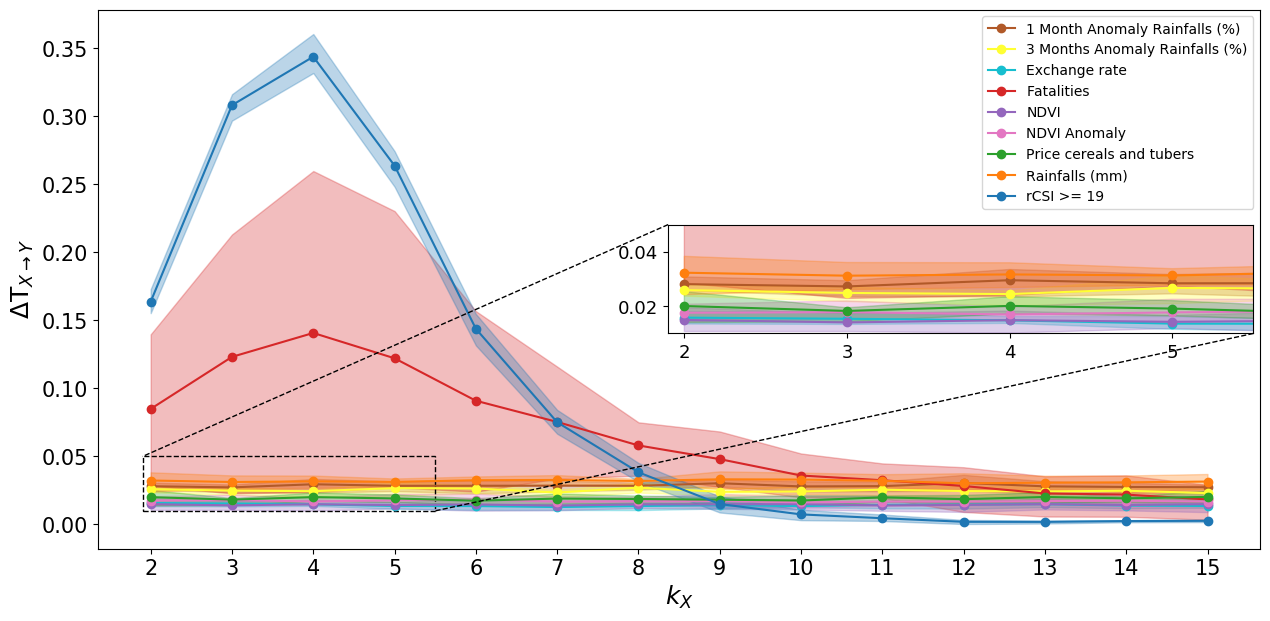

In [23]:
with plt.style.context("default"):
    # Define the subplot figure.
    fig, axs = plt.subplots(figsize = (15, 7))
    axins = zoomed_inset_axes(axs, 2., loc = "right")
    for i,indicator in enumerate(df_results_X.columns.get_level_values(1).unique()):
        subdf = df_results_X.xs(indicator, axis = 1, level = 1, drop_level = False)
        subdf.index = subdf.index + 1
        value_statistic = subdf.agg([lambda x: x.quantile(0.25), np.mean, lambda x: x.quantile(0.75)], axis = 1)
        value_statistic.columns = ["lower_quantile", "mean", "upper_quantile"]
        # Plot.
        value_statistic["mean"].plot(style = ".-", label = indicator, ax = axs, ms = 12, c = colors[indicator])
        value_statistic["mean"].plot(style = ".-", label = indicator, ax = axins, ms = 12, c = colors[indicator])
        axs.fill_between(x = value_statistic["mean"].index, y1 = value_statistic["lower_quantile"], 
                         y2 = value_statistic["upper_quantile"], color = colors[indicator], alpha = 0.3)
        axins.fill_between(x = value_statistic["mean"].index, y1 = value_statistic["lower_quantile"], 
                           y2 = value_statistic["upper_quantile"], color = colors[indicator], alpha = 0.3)
        axins.set_xticks(np.arange(1, 6))
        axins.tick_params(labelsize = 13)
        # Set attributes of the plot.
        axs.legend(loc = "best", prop = {"size": 10})
        axs.set_xlabel("$k_{X}$", fontsize = 18)
        axs.set_ylabel(r'$\Delta$T$_{X \rightarrow Y}$', fontsize = 18)
        axs.tick_params(labelsize = 15)
        axs.set_xticks(np.arange(2, 16))

    axins.set_xlim(1.9, 5.5)
    axins.set_ylim(0.01, 0.05)
    mark_inset(axs, axins, loc1 = 2, loc2 = 4, fc = "none", ec = "black", linestyle  = "--")
    # Save the figure.
    fig.savefig("./output_images/Lags_%s.png" % COUNTRY, bbox_inches = "tight", dpi = 300)